In [100]:
# from google.colab import drive
# drive.mount('/content/drive')

In [101]:
# cd /content/drive/MyDrive/gammaAE/Simulation_study

Consider a model

\begin{align}
    Z & \sim p(z)  = 
    t_q(\mathbf{0}_q, D, \nu), \\[2mm]
    X_\theta|Z & \sim p_\theta(x|z) = 
    t_p\left(
        f_\theta(z), 
        \frac{1 + \nu^{-1} z^\intercal D^{-1} z}{1 + \nu^{-1} q} \Lambda, \nu+q 
    \right). 
\end{align}

If $f_\theta(z) = Az + b$, then

\begin{align}
    \begin{bmatrix}
        X_\theta \\ Z 
    \end{bmatrix} 
    & \sim
    t_{p+q} \left(
        \begin{bmatrix}
            b \\ \mathbf{0}_q
        \end{bmatrix}, 
        \begin{bmatrix}
            ADA^\intercal + \Lambda & AD \\
            DA^\intercal             & D
        \end{bmatrix}, 
        \nu
    \right), \\[5mm]
    X_\theta
    & \sim 
    t_p \left(
        b, ADA^\intercal + \Lambda, \nu
    \right)
    \\
    Z|X_\theta 
    & \sim t_q \left(
        DA^\intercal \left(
            ADA^\intercal + \Lambda
        \right)^{-1}(x - b), 
        \frac{\nu + (x-b)^\intercal \left(
            ADA^\intercal + \Lambda
        \right)^{-1} (x-b)}{\nu+p}\left(
            D - DA^\intercal \left(
                ADA^\intercal + \Lambda
            \right)^{-1} AD
        \right), 
        \nu+p
    \right)
\end{align}

If $D = I_q$ and $\Lambda = \sigma^2 I_p$, then 

\begin{align}
    \begin{bmatrix}
        X_\theta \\ Z 
    \end{bmatrix} 
    & \sim
    t_{p+q} \left(
        \begin{bmatrix}
            b \\ \mathbf{0}_q
        \end{bmatrix}, 
        \begin{bmatrix}
            AA^\intercal + \sigma^2 I_p & A \\
            A^\intercal             & I_q
        \end{bmatrix}, 
        \nu
    \right), \\[5mm]
    X_\theta
    & \sim 
    t_p \left(
        b, AA^\intercal + \sigma^2 I_p, \nu
    \right)
    \\
    Z|X_\theta 
    & \sim t_q \left(
        A^\intercal \left(
            AA^\intercal + \sigma^2 I_p
        \right)^{-1}(x - b), 
        \frac{\nu + (x-b)^\intercal \left(
            AA^\intercal + \sigma^2 I_p
        \right)^{-1} (x-b)}{\nu+p}\left(
            I_q - A^\intercal \left(
                AA^\intercal + \sigma^2 I_p
            \right)^{-1} A
        \right), 
        \nu+p
    \right)
\end{align}

In [4]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from simul_util import make_reproducibility, sampling, simulation, MYTensorDataset

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device(f'cuda:0' if USE_CUDA else "cpu")

# index = 1
# p_dim = 2
# q_dim = 1
# nu = nu_sample = 5
# epochs = 50
# num_layers = 128
# recon_sigma = 0.5
# sample_N = 1000
# batch_size = 64
# make_reproducibility(3000)

# index = 2
# p_dim = 2
# q_dim = 1
# nu = nu_sample = 10
# epochs = 100
# num_layers = 128
# recon_sigma = 0.25
# sample_N = 500
# batch_size = 64
# make_reproducibility(1000)

# index = 3
# p_dim = 2
# q_dim = 1
# nu = nu_sample = 10
# epochs = 100
# num_layers = 128
# recon_sigma = 0.25
# sample_N = 500
# batch_size = 32
# make_reproducibility(1000)

index = 4
p_dim = 2
q_dim = 1
nu = nu_sample = 3
epochs = 50
num_layers = 128
recon_sigma = 0.25
sample_N = 800
batch_size = 16
make_reproducibility(5000)

A = torch.randn(p_dim, q_dim)
b = torch.randn(p_dim)
# nu_sample = 2.5

t_sample = simulation(
    DEVICE, p_dim=p_dim, SEED=1500,
    K=1, N_list=[sample_N],
    mu_list=[b],
    var_list=[recon_sigma**2 * torch.eye(p_dim) + A @ A.T],
    nu_list=[nu_sample]
)

normal_sample = simulation(
    DEVICE, p_dim=p_dim, SEED=1500,
    K=1, N_list=[sample_N],
    mu_list=[b],
    var_list=[recon_sigma**2 * torch.eye(p_dim) + A @ A.T],
    nu_list=[0]
)

simulation_trainset = MYTensorDataset(t_sample)
contrast_trainset = MYTensorDataset(normal_sample)


C:\Users\Kwon\AppData\Local\Temp\ipykernel_20988\1118677338.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize_2D(t_sample).show()
C:\Users\Kwon\AppData\Local\Temp\ipykernel_20988\1118677338.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize_2D(normal_sample).show()


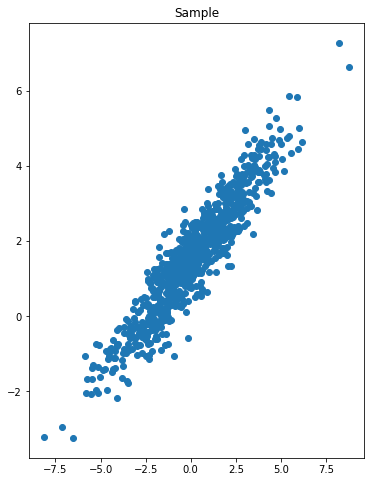

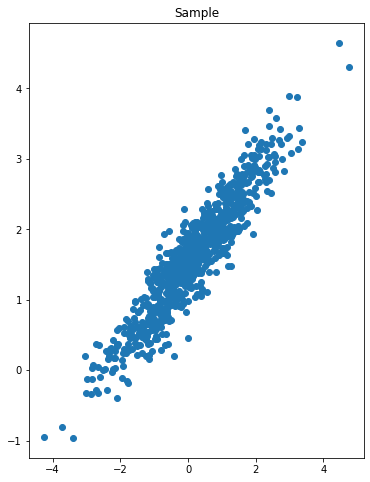

In [5]:
import matplotlib.pyplot as plt
from simul_visualize import visualize_2D, visualize_3D, total_visualize_2D, total_visualize_3D


# visualize_3D(t_sample).show()
visualize_2D(t_sample).show()
visualize_2D(normal_sample).show()

In [104]:
# MVT_true_recon = [(A @ x + b).reshape(1,2) for x in MVT_prior]
# visualize_2D(torch.cat(MVT_true_recon)).show()

In [105]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from simul_loss import log_t_normalizing_const, gamma_regularizer
# from simul_model import Encoder, Decoder, gammaAE
from simul_shallow import Shallow_Encoder, Shallow_Decoder, Shallow_gammaAE

gAE = Shallow_gammaAE(simulation_trainset, p_dim, q_dim, nu, DEVICE, num_layers = num_layers, recon_sigma = recon_sigma, batch_size = batch_size)
VAE = Shallow_gammaAE(simulation_trainset, p_dim, q_dim, 0 , DEVICE, num_layers = num_layers, recon_sigma = recon_sigma, batch_size = batch_size)

epoch_tqdm = tqdm(range(0, epochs))
for epoch in epoch_tqdm : 
    # print(f'\nEpoch {epoch}')
    gAE.train(epoch)
    VAE.train(epoch)

100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


In [106]:
print(gAE.decoder.fc.weight)
print(A)

print(gAE.decoder.fc.bias)
print(b)

print(gAE.encoder.latent_mu.weight)
print(A.T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)))

print(gAE.encoder.latent_mu.bias)
print(A.T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)) @ b)



Parameter containing:
tensor([[-0.7194],
        [-0.6630]], requires_grad=True)
tensor([[1.2260],
        [0.7785]])
Parameter containing:
tensor([-0.3994,  0.9687], requires_grad=True)
tensor([0.1723, 1.6410])
Parameter containing:
tensor([[-1.0240,  0.0181]], requires_grad=True)
tensor([[0.5646, 0.3585]])
Parameter containing:
tensor([-0.7650], requires_grad=True)
tensor([0.6855])


In [107]:
MVT_prior = sampling(sample_N, torch.zeros(q_dim), torch.eye(q_dim), nu, DEVICE)
MVN_prior = sampling(sample_N, torch.zeros(q_dim), torch.eye(q_dim), 0, DEVICE)

gAE_reconstruction = gAE.decoder.sampling(gAE.encoder(t_sample)[0]).detach().cpu().numpy()
VAE_reconstruction = VAE.decoder.sampling(VAE.encoder(t_sample)[0]).detach().cpu().numpy()

gAE_sample = gAE.decoder.sampling(MVT_prior).detach().cpu().numpy()
VAE_sample = VAE.decoder.sampling(MVN_prior).detach().cpu().numpy()

std: torch.Size([500, 2])
v: tensor([12.0601])
const: tensor([[-1.1992e-01,  1.0662e-01],
        [-1.9688e-01, -2.5480e-01],
        [ 3.1608e-01,  1.4015e-01],
        [ 2.7047e-01, -2.0922e-02],
        [-2.0860e-02,  1.0908e-01],
        [ 1.6832e-02,  2.1866e-01],
        [-1.4407e-01,  6.2103e-02],
        [-1.5013e-01,  7.6805e-02],
        [-1.0202e-01,  3.8688e-01],
        [ 5.7012e-01,  5.9007e-01],
        [ 2.3216e-02,  2.8877e-01],
        [ 2.5605e-02,  5.5842e-03],
        [-5.5906e-02, -4.8648e-02],
        [ 4.9129e-01, -2.1160e-01],
        [ 2.0044e-01, -1.4166e-01],
        [-1.2500e-01,  4.3835e-02],
        [ 6.2934e-02, -2.1890e-01],
        [ 1.6928e-01, -3.3901e-01],
        [ 1.2567e-01,  2.5231e-01],
        [ 4.7349e-02, -6.4198e-02],
        [-1.8932e-01,  2.0375e-01],
        [ 8.5932e-02, -1.9547e-02],
        [ 5.4953e-02,  8.1956e-02],
        [ 1.8167e-01,  1.2390e-01],
        [ 1.4536e-01,  5.1189e-02],
        [-7.6228e-02,  7.5651e-02],
        [-

C:\Users\Kwon\AppData\Local\Temp\ipykernel_8144\309256852.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize_3D(torch.cat([x_sample, var_recon], axis = 1).detach()).show()
C:\Users\Kwon\AppData\Local\Temp\ipykernel_8144\309256852.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize_3D(torch.cat([x_sample, torch.as_tensor(true_var_list).to(DEVICE).unsqueeze(1)], axis = 1).detach()).show()


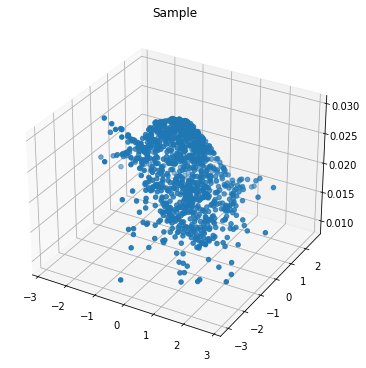

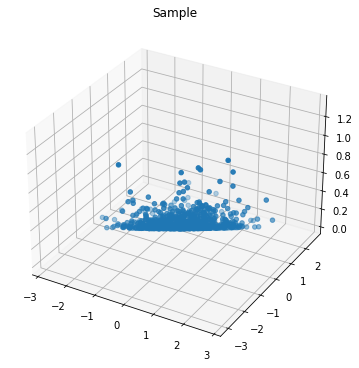

In [108]:
x_sample = sampling(1000, torch.zeros(p_dim), torch.eye(p_dim), nu, DEVICE)
var_recon = torch.exp(gAE.encoder.latent_var(x_sample))


def true_var(x, p_dim, q_dim, A, b, nu, recon_sigma) : 
    term1 = (nu + (x - b).T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)) @ (x - b)) / (nu + p_dim)
    term2 = torch.eye(q_dim) - A.T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)) @ A
    return term1 * term2

true_var_list = [
    true_var(x.cpu(), p_dim, q_dim, A, b, nu, recon_sigma) for x in x_sample
]
torch.as_tensor(true_var_list).unsqueeze(1).shape
torch.cat([x_sample, torch.as_tensor(true_var_list).to(DEVICE).unsqueeze(1)], axis = 1)

visualize_3D(torch.cat([x_sample, var_recon], axis = 1).detach()).show()

visualize_3D(torch.cat([x_sample, torch.as_tensor(true_var_list).to(DEVICE).unsqueeze(1)], axis = 1).detach()).show()


C:\Users\Kwon\AppData\Local\Temp\ipykernel_8144\2306685768.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  VAE_reconstruction, VAE_sample).show()


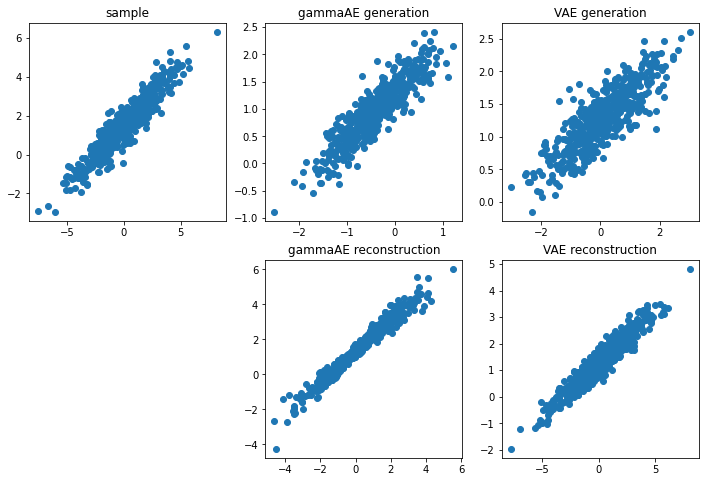

In [111]:
total_visualize_2D(t_sample, gAE_reconstruction, gAE_sample, 
                   VAE_reconstruction, VAE_sample).show()
# total_visualize_3D(t_sample, gAE_reconstruction, gAE_sample, 
#                    VAE_reconstruction, VAE_sample).show()

In [110]:
import pandas as pd

pd.DataFrame(normal_sample).to_csv(f'n_sample_{index}.csv', index = False)
pd.DataFrame(t_sample).to_csv(f't_sample_{index}.csv', index = False)
pd.DataFrame(gAE_reconstruction).to_csv(f'gAE_recon_{index}.csv', index = False)
pd.DataFrame(VAE_reconstruction).to_csv(f'VAE_recon_{index}.csv', index = False)
pd.DataFrame(gAE_sample).to_csv(f'gAE_gen_{index}.csv', index = False)
pd.DataFrame(VAE_sample).to_csv(f'VAE_gen_{index}.csv', index = False)